# HSCT survival: XGBoost models datasets test

## 1. Notebook set-up

### 1.1. Imports & options

In [1]:
# PyPI imports
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Internal imports
import configuration as config
import functions.helper as helper_funcs

notebook_num='01.3'
gpu=0

pd.set_option('display.max_rows', 500)
# os.environ['OMP_NUM_THREADS']='4'

### 1.2. Parameters

In [2]:
# Run options
regression_test=False
classification_test=False

### 1.3. Files

In [3]:
# Dataset definition file
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'

# Save the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Dataset testing results
regression_test_results_file=f'{config.RESULTS}/{notebook_num}-regression_test_results.pkl'
regression_training_performance_plots=f'{config.PLOTS}/{notebook_num}-regression_training_performance.jpg'
regression_test_performance_plots=f'{config.PLOTS}/{notebook_num}-regression_test_performance.jpg'
regression_test_residuals_plots=f'{config.PLOTS}/{notebook_num}-regression_test_residuals.jpg'
classification_test_results_file=f'{config.RESULTS}/{notebook_num}-classification_test_results.pkl'
classification_test_performance_plots=f'{config.PLOTS}/{notebook_num}-classification_test_performance.jpg'
classification_test_probability_plots=f'{config.PLOTS}/{notebook_num}-classification_test_probability.jpg'

## 2. XGBoost regression model

### 2.1. Hyperparameter optimization

In [4]:
%%time

if regression_test == True:

    # Define the hyperparameter search space
    search_space={
        'objective': ['reg:squarederror'],
        'eval_metric': ['rmse'],
        'gpu_id': [gpu],
        'tree_method': ['gpu_hist'],
        'seed': [315],
        'learning_rate': [0.005,0.01],
        'max_depth': [4,6,8,10],
        'gamma': [0.01,0.02,0.04,0.06],
        'subsample': [0.3,0.4,0.5,0.6]
    }

    regression_predictions={
        'Training':{},
        'Testing':{}
    }

    # Loop on the datasets
    for dataset, data_file in datasets.items():

        # Load the data
        with open(data_file, 'rb') as input_file:
            data_dict=pickle.load(input_file)

        # Prepare data for training
        training_labels_df=data_dict['Training labels']
        training_features_df=data_dict['Training features']
        testing_labels_df=data_dict['Testing labels']
        testing_features_df=data_dict['Testing features']

        training_labels_df['efs_time']=np.log(training_labels_df['efs_time'])
        testing_labels_df['efs_time']=np.log(testing_labels_df['efs_time'])

        dtraining=xgb.DMatrix(training_features_df, label=training_labels_df['efs_time'])
        dtesting=xgb.DMatrix(testing_features_df, label=testing_labels_df['efs_time'])

        results_df=helper_funcs.xgb_hyperparameter_search(
            search_space,
            training_features_df,
            training_labels_df['efs_time']
        )

        winning_hyperparameters=dict(results_df.iloc[-1]['Hyperparameters'])
        
        print(f'\n{dataset}:')
        for parameter, value in winning_hyperparameters.items():
            print(f' {parameter}: {value}')

        # Train classifier with best hyperparameters on complete training set
        tree_model=xgb.train(
            winning_hyperparameters,
            dtraining,
            num_boost_round=1000,
            evals=[(dtraining, 'training')],
            early_stopping_rounds=100,
            verbose_eval=0
        )

        # Make training predictions
        predictions=tree_model.predict(dtraining)
        regression_predictions['Training'][dataset]=predictions

        # Make testing predictions
        predictions=tree_model.predict(dtesting)
        regression_predictions['Testing'][dataset]=predictions

    with open(regression_test_results_file, 'wb') as output_file:
        pickle.dump(regression_predictions, output_file)

else:

    # Load last result
    with open(regression_test_results_file, 'rb') as input_file:
        regression_predictions=pickle.load(input_file)

print()


CPU times: user 1.93 ms, sys: 804 µs, total: 2.73 ms
Wall time: 12.6 ms


### 2.2. Results

#### 2.2.1. Scores

##### 2.2.1.1. Training data

In [5]:
scoring_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

for dataset in regression_predictions['Training'].keys():

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    scoring_results=helper_funcs.score_predictions(
        dataset,
        regression_predictions['Training'][dataset],
        np.log(data_dict['Training labels']['efs_time'].values),
        data_dict['Training labels']['efs'].values,
        data_dict['Training race group'],
        data_dict['Training IDs'],
        results=scoring_results
    )

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head(len(scoring_results_df))

,Model,RMSE,C-index,Stratified C-index
0,"Nominal one-hot/ordinal encoded, NANs encoded",0.838370,0.749025,0.737084
1,"Nominal one-hot/ordinal encoded, NANs imputed",0.838370,0.749025,0.737084
2,"All ordinal encoded, NAN encoded",0.832719,0.752507,0.740338
3,"All ordinal encoded, NAN imputed",0.827709,0.756242,0.744241
4,Binary target encoded,0.836362,0.751115,0.737945
5,Continuous target encoded,0.837593,0.747122,0.735769


##### 2.2.1.2. Testing data

In [6]:
scoring_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

for dataset in regression_predictions['Testing'].keys():

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    scoring_results=helper_funcs.score_predictions(
        dataset,
        regression_predictions['Testing'][dataset],
        np.log(data_dict['Testing labels']['efs_time'].values),
        data_dict['Testing labels']['efs'].values,
        data_dict['Testing race group'],
        data_dict['Testing IDs'],
        results=scoring_results
    )

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head(len(scoring_results_df))

,Model,RMSE,C-index,Stratified C-index
0,"Nominal one-hot/ordinal encoded, NANs encoded",0.946139,0.661795,0.651172
1,"Nominal one-hot/ordinal encoded, NANs imputed",0.946139,0.661795,0.651172
2,"All ordinal encoded, NAN encoded",0.945693,0.662157,0.651902
3,"All ordinal encoded, NAN imputed",0.948026,0.659946,0.650691
4,Binary target encoded,0.947345,0.662898,0.651749
5,Continuous target encoded,0.945538,0.663125,0.654595


#### 2.2.2. Prediction plots

##### 2.2.2.1. Training data

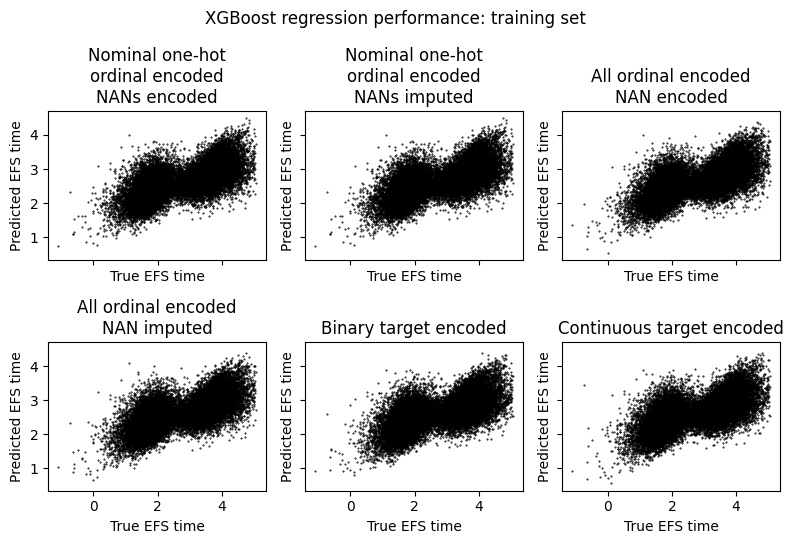

In [7]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('XGBoost regression performance: training set')

for i, dataset in enumerate(regression_predictions['Training'].keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].scatter(
        np.log(data_dict['Training labels']['efs_time'].values),
        regression_predictions['Training'][dataset],
        color='black',
        s=0.2
    )
    axs[i].set_xlabel('True EFS time')
    axs[i].set_ylabel('Predicted EFS time')

fig.tight_layout()
fig.savefig(regression_training_performance_plots, dpi=300, bbox_inches='tight')
fig.show()

##### 2.2.2.2. Testing data

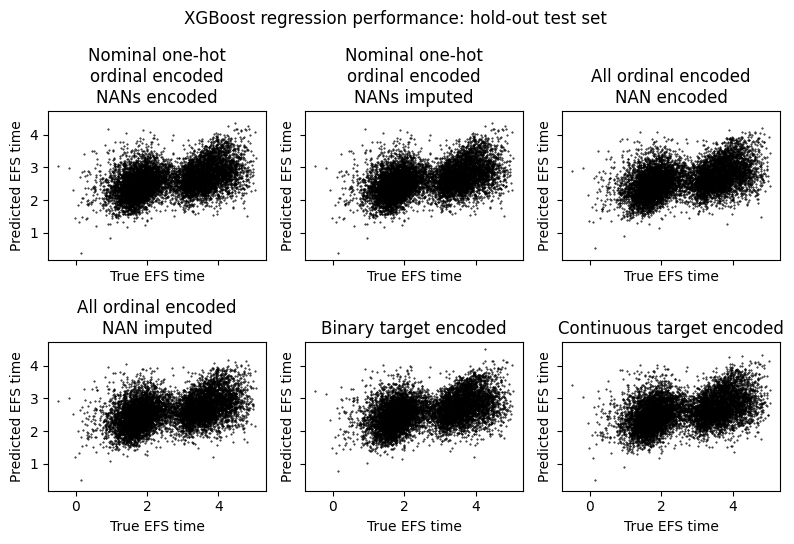

In [8]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('XGBoost regression performance: hold-out test set')

for i, dataset in enumerate(regression_predictions['Testing'].keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].scatter(
        np.log(data_dict['Testing labels']['efs_time'].values),
        regression_predictions['Testing'][dataset],
        color='black',
        s=0.2
    )
    axs[i].set_xlabel('True EFS time')
    axs[i].set_ylabel('Predicted EFS time')

fig.tight_layout()
fig.savefig(regression_test_performance_plots, dpi=300, bbox_inches='tight')
fig.show()

#### 2.2.3. Residual plots

##### 2.2.3.1. Training data

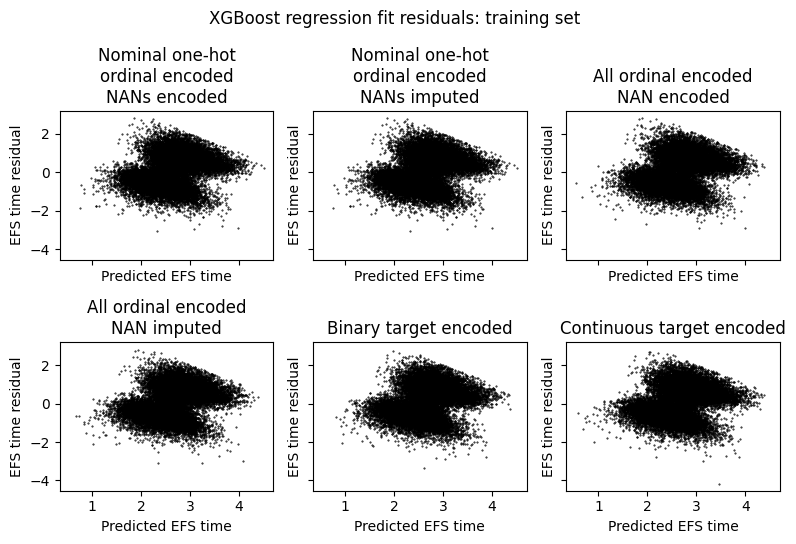

In [9]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('XGBoost regression fit residuals: training set')

for i, dataset in enumerate(regression_predictions['Training'].keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].scatter(
        regression_predictions['Training'][dataset],
        np.log(data_dict['Training labels']['efs_time'].values) - regression_predictions['Training'][dataset],
        color='black',
        s=0.2
    )
    axs[i].set_xlabel('Predicted EFS time')
    axs[i].set_ylabel('EFS time residual')

fig.tight_layout()
fig.savefig(regression_test_residuals_plots, dpi=300, bbox_inches='tight')
fig.show()

##### 2.2.3.2. Testing data

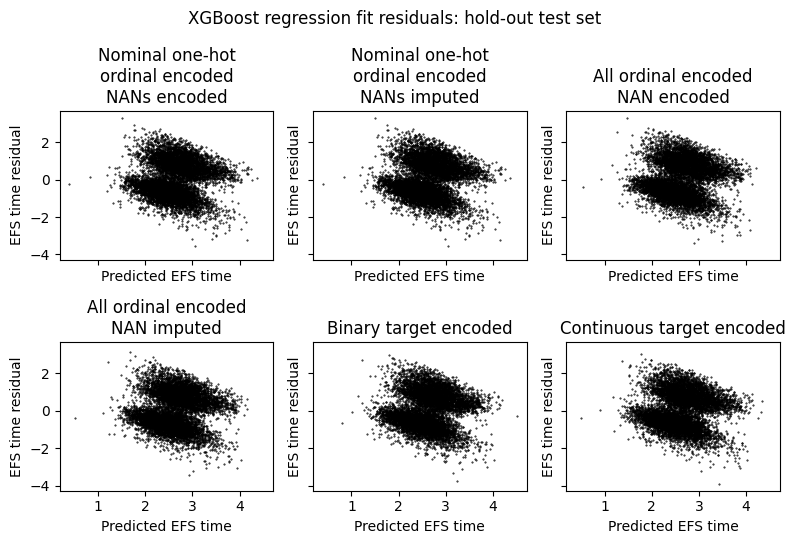

In [10]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('XGBoost regression fit residuals: hold-out test set')

for i, dataset in enumerate(regression_predictions['Testing'].keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].scatter(
        regression_predictions['Testing'][dataset],
        np.log(data_dict['Testing labels']['efs_time'].values) - regression_predictions['Testing'][dataset],
        color='black',
        s=0.2
    )
    axs[i].set_xlabel('Predicted EFS time')
    axs[i].set_ylabel('EFS time residual')

fig.tight_layout()
fig.savefig(regression_test_residuals_plots, dpi=300, bbox_inches='tight')
fig.show()

## 3. XGBoost classification model

### 3.1. Hyperparameter optimization

In [ ]:
%%time

if classification_test == True:

    classification_predictions={
        'Training':{},
        'Testing':{}
    }

    # Loop on the datasets
    for dataset, data_file in datasets.items():

        # Load the data
        with open(data_file, 'rb') as input_file:
            data_dict=pickle.load(input_file)

        # Prepare data for training
        training_labels_df=data_dict['Training labels']
        training_features_df=data_dict['Training features']
        testing_labels_df=data_dict['Testing labels']
        testing_features_df=data_dict['Testing features']

        dtraining=xgb.DMatrix(training_features_df, label=training_labels_df['efs'])
        dtesting=xgb.DMatrix(testing_features_df, label=testing_labels_df['efs'])

        # Calculated class weighting
        class_weight=(len(training_labels_df) - sum(training_labels_df['efs'])) / sum(training_labels_df['efs'])

        # Define the hyperparameter search space
        search_space={
            'objective': ['binary:logistic'],
            'eval_metric': ['logloss'],
            'gpu_id': [gpu],
            'tree_method': ['gpu_hist'],
            'scale_pos_weight': [class_weight],
            'seed': [315],
            'learning_rate': [0.005,0.01],
            'max_depth': [4,6,8,10],
            'gamma': [0.01,0.02,0.04,0.06],
            'subsample': [0.3,0.4,0.5,0.6]
        }

        results_df=helper_funcs.xgb_hyperparameter_search(
            search_space,
            training_features_df,
            training_labels_df['efs']
        )

        winning_hyperparameters=dict(results_df.iloc[-1]['Hyperparameters'])
        
        print(f'\n{dataset}:')
        for parameter, value in winning_hyperparameters.items():
            print(f' {parameter}: {value}')

        # Train classifier with best hyperparameters on complete training set
        tree_model=xgb.train(
            winning_hyperparameters,
            dtraining,
            num_boost_round=1000,
            evals=[(dtraining, 'training')],
            early_stopping_rounds=10,
            verbose_eval=0
        )

        # Make training predictions
        predictions=tree_model.predict(dtraining)
        classification_predictions['Training'][dataset]=predictions

        # Make testing predictions
        predictions=tree_model.predict(dtesting)
        classification_predictions['Testing'][dataset]=predictions

    with open(classification_test_results_file, 'wb') as output_file:
        pickle.dump(classification_predictions, output_file)

else:

    # Load last result
    with open(classification_test_results_file, 'rb') as input_file:
        classification_predictions=pickle.load(input_file)

print()


CPU times: user 1.07 ms, sys: 134 µs, total: 1.21 ms
Wall time: 4.23 ms


### 3.2. Results

#### 3.2.1. Confusion matrices

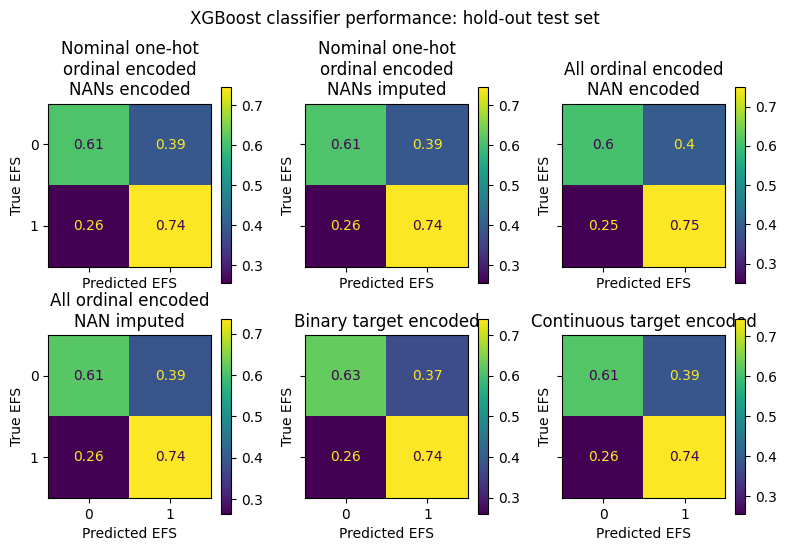

In [12]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('XGBoost classifier performance: hold-out test set')

for i, dataset in enumerate(classification_predictions['Testing'].keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    # Make calls with threshold
    calls=np.where(classification_predictions['Testing'][dataset] < 0.5, 0, 1)

    # Plot the confusion matrix
    cm=confusion_matrix(data_dict['Testing labels']['efs'], calls, normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    _=cm_disp.plot(ax=axs[i])

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].set_xlabel('Predicted EFS')
    axs[i].set_ylabel('True EFS')

fig.tight_layout()
fig.savefig(classification_test_performance_plots, dpi=300, bbox_inches='tight')
fig.show()

#### 3.2.2. Class probabilities

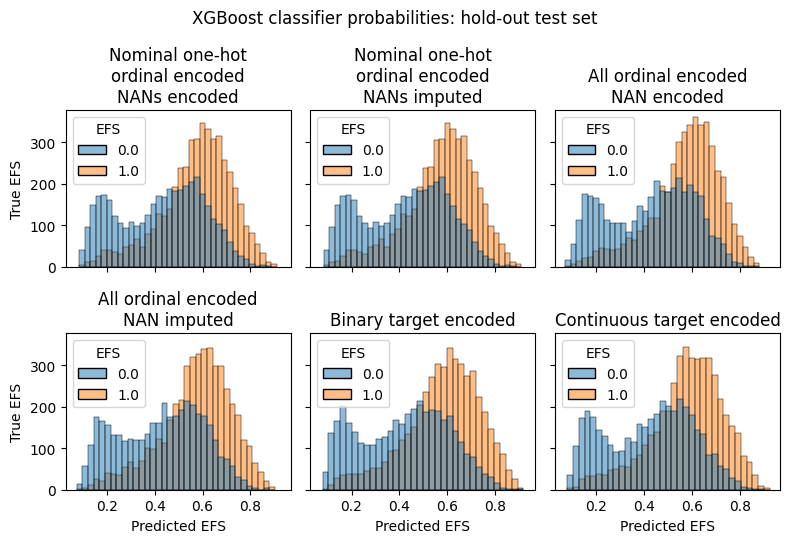

In [13]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('XGBoost classifier probabilities: hold-out test set')

for i, dataset in enumerate(classification_predictions['Testing'].keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    class_df=pd.DataFrame.from_dict({
        'EFS': data_dict['Testing labels']['efs'].values,
        'EFS probability': classification_predictions['Testing'][dataset]
    })

    # Plot the confusion matrix
    sns.histplot(class_df, x='EFS probability', hue='EFS', ax=axs[i])

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].set_xlabel('Predicted EFS')
    axs[i].set_ylabel('True EFS')

fig.tight_layout()
fig.savefig(classification_test_probability_plots, dpi=300, bbox_inches='tight')
fig.show()